# Auto encoder for anomaly detection in bearings vibrational modes: a comparison between GRU and LSTM layers.

A recurrent neural network (RNN) is a type of artificial neural network adapted to work for time series data or data that involves sequences: data points that are not independent one another but present a sequential dependency. RNN, in particular, are capable of storing information on the previous inputs to generate the next output of the sequence accordingly.

The Long Short Term Memory (LSTM) is a kind of RNN with a four-layered structure that helps retaining long-term memory and can be used in several sequential problems including machine translation, speech synthesis, speech recognition, and handwriting recognition.
The gated recurrent unit (GRU), instead, is a variation of LSTM as both have design similarities. GRU uses an update gate and reset gate to decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information.

In this project, the anomaly detection strategy adopted at the following 

https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf,

for vibration sensor readings of four bearings from the NASA Acoustics and Vibration Database, were exploited to compare the functioning of an autoencoder made with LSTM layers and GRU layers. 

# Bearing failure anomaly detection

Considering the data taken from vibration sensor readings from the NASA Acoustics and Vibration Database as our dataset for this study, sensor readings were taken on four bearings that were run to failure under constant load over multiple days.
Defining two autoencorders, one with LSTM layers and the other with GRU layers, two respective thresholds signaling the failure start are found. The performance of the two models is compared via the evaluation of the root mean squared error.

# The dataset

The dataset consists in a set of files containing each a 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the four bearing sensors at a sampling rate of 20 kHz.

In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib
import pylab


from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [2]:
#set random seed
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing

The dataframe is organized in order to have the date as index and be divided into training and test data.

In [3]:
#building of the data frame
data_dir = '.\Bearing_data\Bearing_Sensor_Data_pt1'
merged_data = pd.DataFrame.from_dict({'Bearing 1':[0],'Bearing 2':[0],'Bearing 3':[0],'Bearing 4':[0],'date':['2004.02.12.10.52.39']})

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t', header = None)
    dataset_mean_abs_row = np.array(dataset.abs().mean())
    dataset_mean_abs_row = dataset_mean_abs_row.round(6)
    dataset_mean_abs_date_row = np.append(dataset_mean_abs_row,filename)
    merged_data.loc[len(merged_data)] = dataset_mean_abs_date_row

merged_data = merged_data.drop(0)

#setting 'Date' column as index
df = merged_data.set_index('date')
df = df.iloc[1:, :]
df = df.round(6)

df.index = pd.to_datetime(df.index, format='%Y.%m.%d.%H.%M.%S')
df = df.sort_index()
df.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", df.shape)

Dataset shape: (981, 4)


Training dataset shape: (444, 4)
Test dataset shape: (538, 4)
       Bearing 1 Bearing 2 Bearing 3 Bearing 4
count        981       981       981       981
unique       929       916       930       891
top     0.060783  0.073843  0.076581  0.044156
freq           3         2         3         3


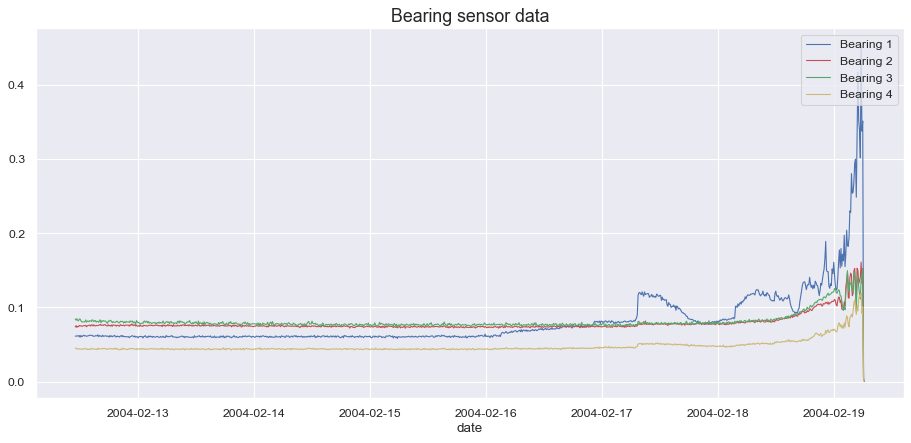

C:\Users\annal\AppData\Local\Temp\ipykernel_17128\199515645.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Bearing 1'] = train['Bearing 1'].astype(float)
C:\Users\annal\AppData\Local\Temp\ipykernel_17128\199515645.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Bearing 2'] = train['Bearing 2'].astype(float)
C:\Users\annal\AppData\Local\Temp\ipykernel_17128\199515645.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

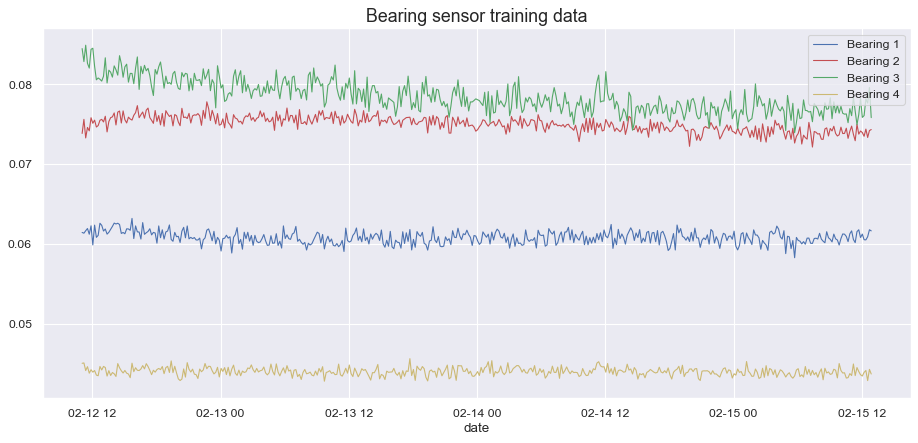

In [4]:
#defining train and test sets
train = df['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = df['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

# Check for invalid values
print(df.describe())

#plot all data

df['Bearing 1'] = df['Bearing 1'].astype(float)
df['Bearing 2'] = df['Bearing 2'].astype(float)
df['Bearing 3'] = df['Bearing 3'].astype(float)
df['Bearing 4'] = df['Bearing 4'].astype(float)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(df['Bearing 1'], 'b', label='Bearing 1', linewidth=1)
ax.plot(df['Bearing 2'], 'r', label='Bearing 2', linewidth=1)
ax.plot(df['Bearing 3'], 'g', label='Bearing 3', linewidth=1)
ax.plot(df['Bearing 4'], 'y', label='Bearing 4', linewidth=1)
ax.set_title('Bearing sensor data', fontsize=16)
ax.set_xlabel('date')
ax.legend(loc='upper right')
plt.show()

#plot train data 
train['Bearing 1'] = train['Bearing 1'].astype(float)
train['Bearing 2'] = train['Bearing 2'].astype(float)
train['Bearing 3'] = train['Bearing 3'].astype(float)
train['Bearing 4'] = train['Bearing 4'].astype(float)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], 'b', label='Bearing 1', linewidth=1)
ax.plot(train['Bearing 2'], 'r', label='Bearing 2', linewidth=1)
ax.plot(train['Bearing 3'], 'g', label='Bearing 3', linewidth=1)
ax.plot(train['Bearing 4'], 'y', label='Bearing 4', linewidth=1)
ax.set_title('Bearing sensor training data', fontsize=16)
ax.set_xlabel('date')
ax.legend(loc='upper right')
plt.show()


In [5]:
#normalizing dataset with MinMaxScaler 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

print("Train data shape pre:", X_train.shape)
print("Test data shape pre:", X_test.shape)

scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

# reshaping inputs for LSTM and GRU models [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Train data shape post:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape post:", X_test.shape)

Train data shape pre: (444, 4)
Test data shape pre: (538, 4)
Train data shape post: (444, 1, 4)
Test data shape post: (538, 1, 4)


# Define autoencoder models

The two models are defined with different configurations: different activation functions and different cell/unit numbers, according to which ones provided the best "Model Loss" plot. The obtained Model Loss plots show the Minimum Absolute Error (MAE) between the values predicted by the model and the train (blue) and validation (red) data epoch by epoch. Better the model predictions, smaller the MAE value.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru (GRU)                   (None, 1, 16)             1056      
                                                                 
 gru_1 (GRU)                 (None, 4)                 264       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 gru_2 (GRU)                 (None, 1, 4)              120       
                                                                 
 gru_3 (GRU)                 (None, 1, 16)             1056      
                                                             

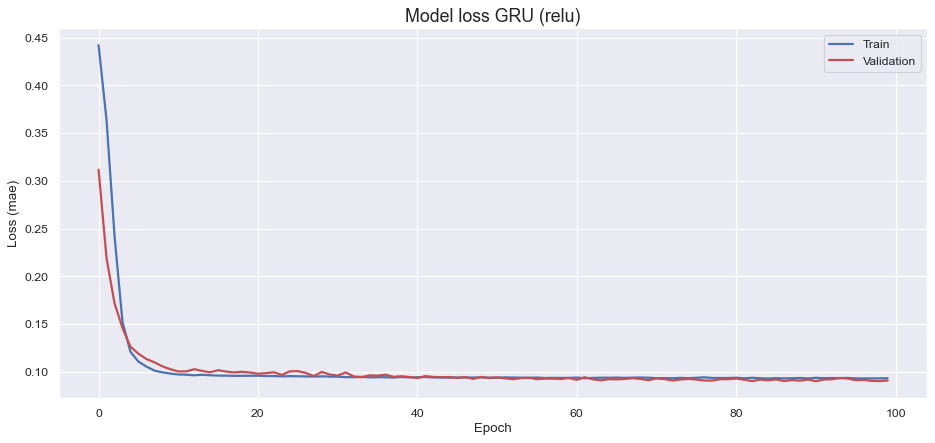

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                           

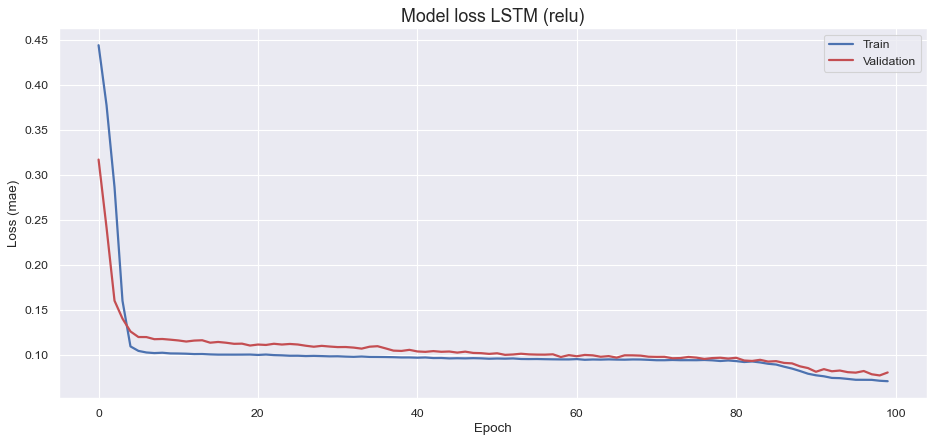

In [6]:
#autoencoder with GRU layers
#definiton of the model
def autoencoder_GRU(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(16,activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(4,activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(4,activation='relu', return_sequences=True)(L3)
    L5 = GRU(16,activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model_GRU = autoencoder_GRU(X_train)
model_GRU.compile(optimizer = 'adam', loss = 'mae')
model_GRU.summary()

nb_epochs = 100
batch_size = 10
history_GRU = model_GRU.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

#plot losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_GRU['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_GRU['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss GRU (relu)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# autoencoder with LSTM layers
#definiton of the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss LSTM (relu)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# Find prediction dataset and confront the two methods

The prediction datasets for train and test data are obtained from the two models separately to make possible the evaluation of the two Root Mean Squared Error (RMSE), which are nontheless the square root of the mean of the MAEs squared. The results show that the model with GRU layers, with the right configuration, is more accurate in predicting data than the LSTM one.

In [7]:
#define prediction train e test GRU e LSTM
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_pred_train_GRU = model_GRU.predict(X_train)
X_pred_train_GRU = X_pred_train_GRU.reshape(X_pred_train_GRU.shape[0], X_pred_train_GRU.shape[2])
X_pred_train_GRU = pd.DataFrame(X_pred_train_GRU, columns=train.columns)
X_pred_train_GRU.index = train.index

X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_pred_test_GRU = model_GRU.predict(X_test)
X_pred_test_GRU = X_pred_test_GRU.reshape(X_pred_test_GRU.shape[0], X_pred_test_GRU.shape[2])
X_pred_test_GRU = pd.DataFrame(X_pred_test_GRU, columns=test.columns)
X_pred_test_GRU.index = test.index

X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index


RSME_LSTM = np.sqrt(mean_squared_error(Xtest,X_pred_test))
RSME_GRU = np.sqrt(mean_squared_error(Xtest,X_pred_test_GRU))

print("RSME GRU = ",RSME_GRU)
print("RSME LSTM = ",RSME_LSTM)

17/17 [==============================] - 0s 4ms/step
RSME GRU =  5.9160065264885535
RSME LSTM =  9.444440813949305


# Build the table for anomaly determination

Eventually, evaluating the Mean Loss Errors for the train data of the two cases, a threshold for the anomaly is set. The information about the MAE and wether the data point is an anomaly or not is reported in the dataset "scored". Returning to the "Date" indices it is possible to notice how, the threshold found, perfectly distinguishes between the values corresponding to regular working bearings and the values corresponding to anomalies due to the breaking of the bearings.

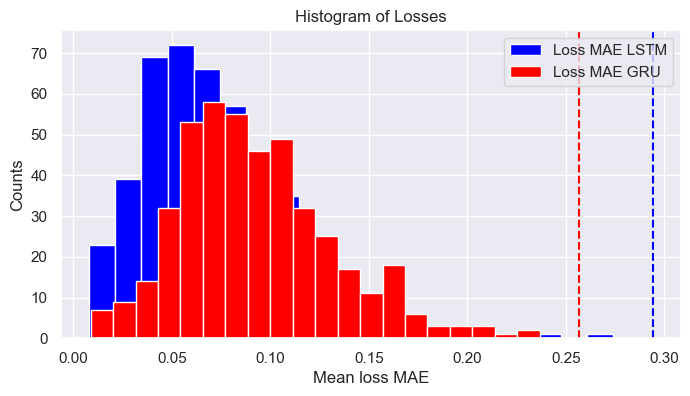

                     Mean loss_mae GRU  Mean loss_mae LSTM  Threshold GRU  \
date                                                                        
2004-02-12 11:02:39           0.236747            0.234973       0.256747   
2004-02-12 11:12:39           0.122976            0.120256       0.256747   
2004-02-12 11:22:39           0.234205            0.274135       0.256747   
2004-02-12 11:32:39           0.162944            0.149538       0.256747   
2004-02-12 11:42:39           0.150119            0.147400       0.256747   

                     Threshold LSTM  Anomaly GRU  Anomaly LSTM  
date                                                            
2004-02-12 11:02:39        0.294135        False         False  
2004-02-12 11:12:39        0.294135        False         False  
2004-02-12 11:22:39        0.294135        False         False  
2004-02-12 11:32:39        0.294135        False         False  
2004-02-12 11:42:39        0.294135        False         False  
     

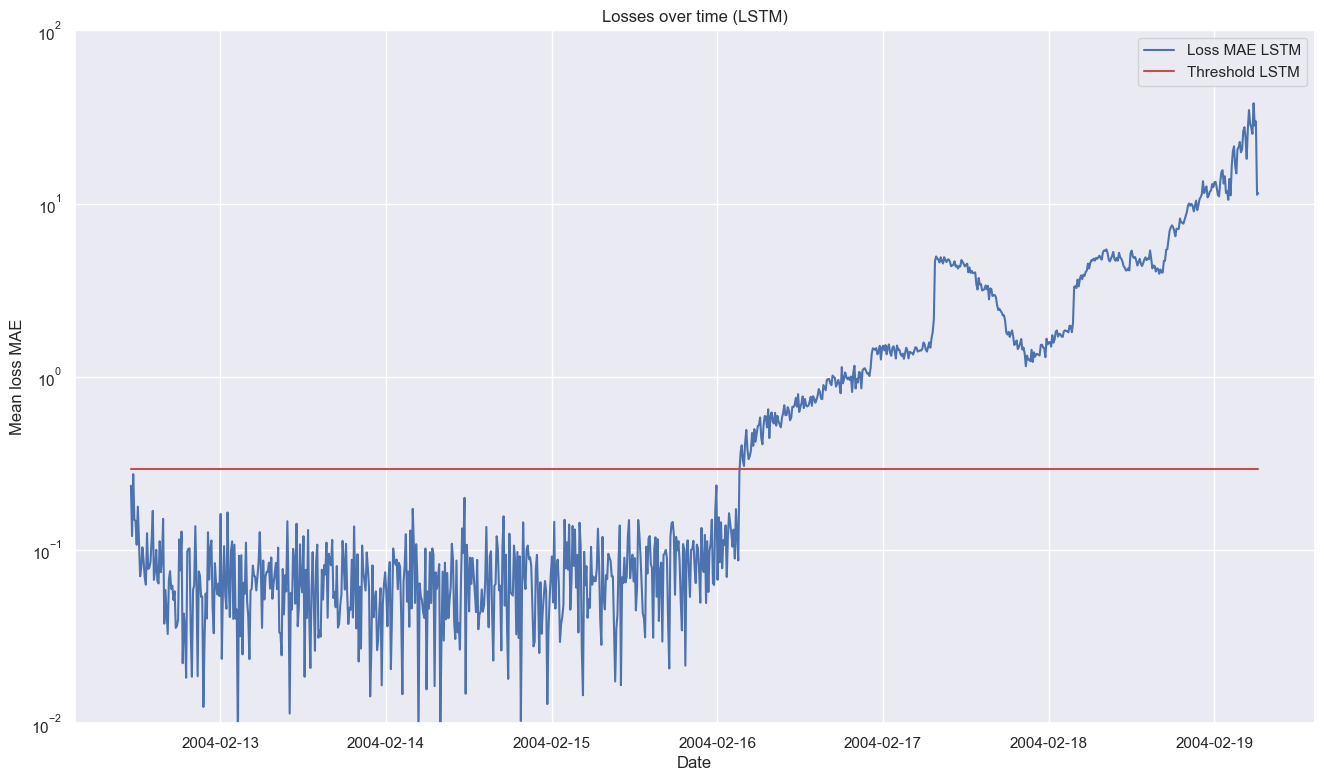

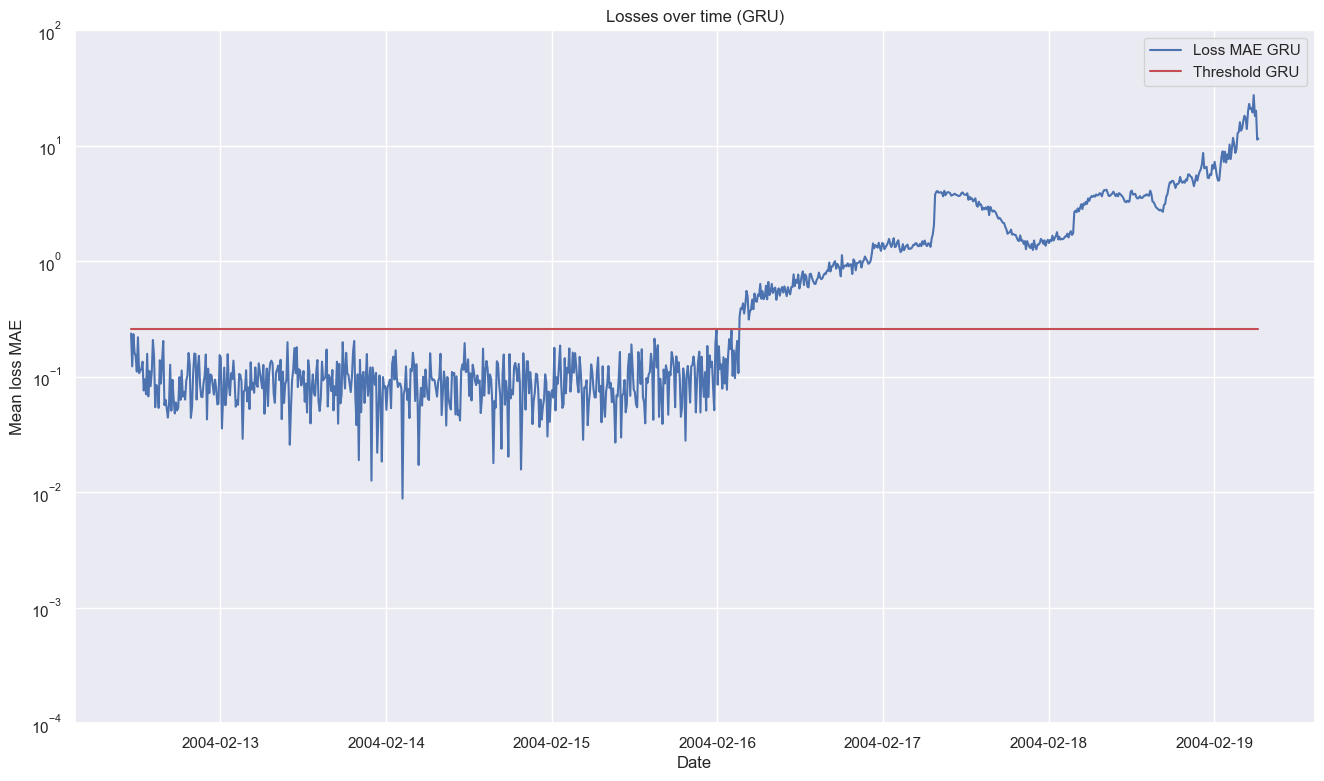

In [8]:
#build score_train
scored_train = pd.DataFrame(index=train.index)
scored_train['Mean loss_mae GRU'] = np.mean(np.abs(X_pred_train_GRU-Xtrain), axis = 1)
scored_train['Mean loss_mae LSTM'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)

#set threshold
thr_GRU = scored_train['Mean loss_mae GRU'].max() + 0.02
thr_LSTM = scored_train['Mean loss_mae LSTM'].max() + 0.02


#plot loss recurrencies 
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(scored_train['Mean loss_mae LSTM'], bins=20, color='blue',label = 'Loss MAE LSTM')
ax.hist(scored_train['Mean loss_mae GRU'], bins=20, color='red',label = 'Loss MAE GRU')
ax.set_title('Histogram of Losses')
ax.set_xlabel('Mean loss MAE')
ax.set_ylabel('Counts')
ax.legend(loc='upper right')
ax.axvline(x= thr_GRU, color='red', linestyle='--')
ax.axvline(x= thr_LSTM, color='blue', linestyle='--')
plt.show()

scored_train['Threshold GRU'] = thr_GRU
scored_train['Threshold LSTM'] = thr_LSTM
scored_train['Anomaly GRU'] = scored_train['Mean loss_mae GRU'] > scored_train['Threshold GRU']
scored_train['Anomaly LSTM'] = scored_train['Mean loss_mae LSTM'] > scored_train['Threshold LSTM']


#build score_test
scored_test = pd.DataFrame(index=test.index)
scored_test['Mean loss_mae GRU'] = np.mean(np.abs(X_pred_test_GRU-Xtest), axis = 1)
scored_test['Mean loss_mae LSTM'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
scored_test['Threshold GRU'] = thr_GRU
scored_test['Threshold LSTM'] = thr_LSTM
scored_test['Anomaly GRU'] = scored_test['Mean loss_mae GRU'] > scored_test['Threshold GRU']
scored_test['Anomaly LSTM'] = scored_test['Mean loss_mae LSTM'] > scored_test['Threshold LSTM']

#merge train and test in score dataframe
scored = pd.concat([scored_train, scored_test])

#check
print(scored_train.head())
print(scored_test.head())

print( "Anomalies according to GRU method",scored['Anomaly GRU'].value_counts()[True])
print("Anomalies according to LSTM method",scored['Anomaly LSTM'].value_counts()[True])


#back to time dependency LSTM
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(scored['Mean loss_mae LSTM'], 'b', label = 'Loss MAE LSTM')
ax.plot(scored['Threshold LSTM'], 'r',label = 'Threshold LSTM')
ax.set_title('Losses over time (LSTM)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean loss MAE')
ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e2)
plt.show()

#back to time dependency GRU
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(scored['Mean loss_mae GRU'], 'b',label = 'Loss MAE GRU')
ax.plot(scored['Threshold GRU'], 'r',label = 'Threshold GRU')
ax.set_title('Losses over time (GRU)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean loss MAE')
ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_ylim(1e-4,1e2)
plt.show()

It is clear how the two methods, LSTM and GRU, are equivalent for the example just shown.

# What if the models were defined under different conditions (in terms of activation function and number of cells/units)? 

Activation function: tanh 

Number of cells/units: 4-16

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru_4 (GRU)                 (None, 1, 16)             1056      
                                                                 
 gru_5 (GRU)                 (None, 4)                 264       
                                                                 
 repeat_vector_2 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 gru_6 (GRU)                 (None, 1, 4)              120       
                                                                 
 gru_7 (GRU)                 (None, 1, 16)             1056      
                                                           

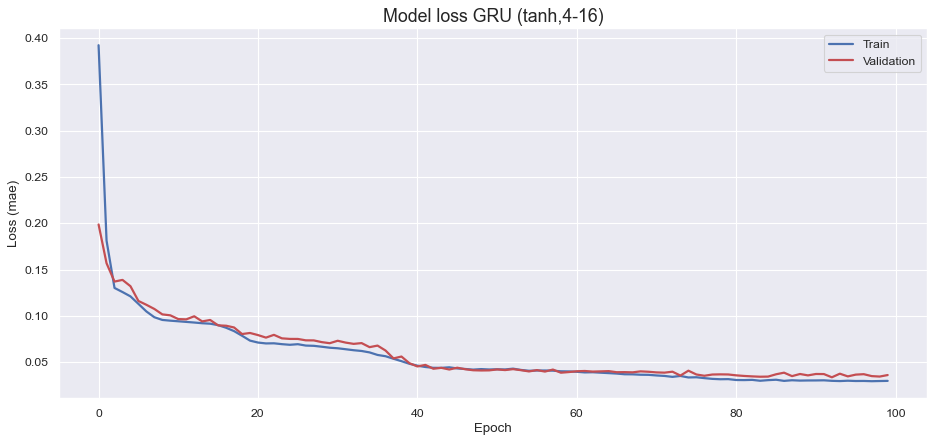

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1344      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_3 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

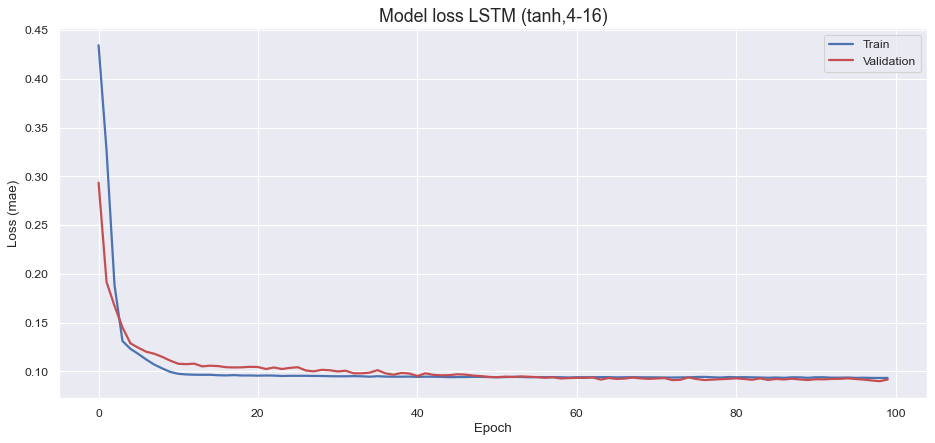

17/17 [==============================] - 1s 2ms/step
RSME GRU =  6.598468114572936
RSME LSTM =  6.737351638304838


In [9]:
#autoencoder with GRU layers
#definiton of the model
def autoencoder_GRU(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(16,activation='tanh', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(4,activation='tanh', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(4,activation='tanh', return_sequences=True)(L3)
    L5 = GRU(16,activation='tanh', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model_GRU = autoencoder_GRU(X_train)
model_GRU.compile(optimizer = 'adam', loss = 'mae')
model_GRU.summary()

nb_epochs = 100
batch_size = 10
history_GRU = model_GRU.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

#plot losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_GRU['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_GRU['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss GRU (tanh,4-16)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# autoencoder with LSTM layers
#definiton of the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='tanh', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='tanh', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='tanh', return_sequences=True)(L3)
    L5 = LSTM(16, activation='tanh', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss LSTM (tanh,4-16)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_pred_test_GRU = model_GRU.predict(X_test)
X_pred_test_GRU = X_pred_test_GRU.reshape(X_pred_test_GRU.shape[0], X_pred_test_GRU.shape[2])
X_pred_test_GRU = pd.DataFrame(X_pred_test_GRU, columns=test.columns)
X_pred_test_GRU.index = test.index

X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index


RSME_LSTM = np.sqrt(mean_squared_error(Xtest,X_pred_test))
RSME_GRU = np.sqrt(mean_squared_error(Xtest,X_pred_test_GRU))

print("RSME GRU = ",RSME_GRU)
print("RSME LSTM = ",RSME_LSTM)


Activation function: tanh

Number of cells/units: 16-32

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru_8 (GRU)                 (None, 1, 32)             3648      
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 repeat_vector_4 (RepeatVec  (None, 1, 16)             0         
 tor)                                                            
                                                                 
 gru_10 (GRU)                (None, 1, 16)             1632      
                                                                 
 gru_11 (GRU)                (None, 1, 32)             4800      
                                                           

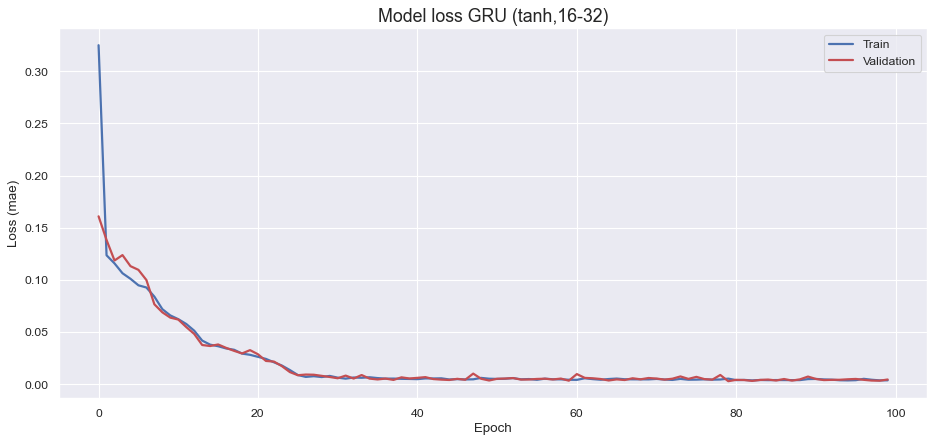

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 32)             4736      
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_5 (RepeatVec  (None, 1, 16)             0         
 tor)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 1, 16)             2112      
                                                                 
 lstm_11 (LSTM)              (None, 1, 32)             6272      
                                                           

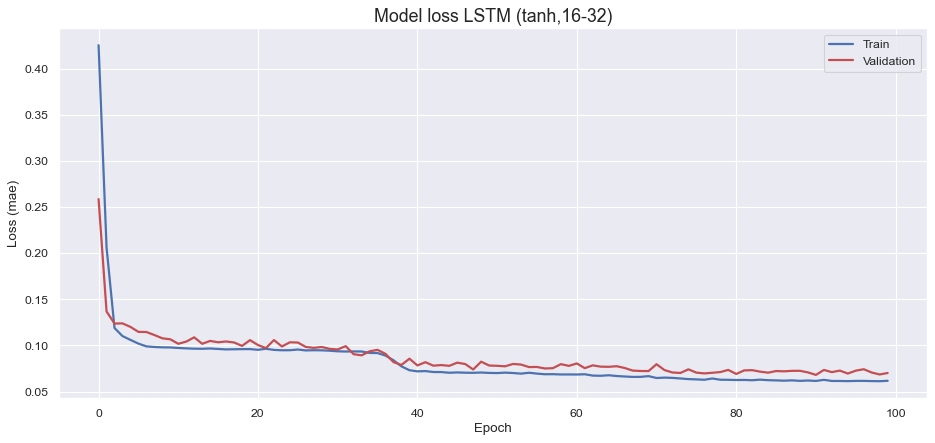

17/17 [==============================] - 1s 4ms/step
RSME GRU =  6.3726767123907475
RSME LSTM =  6.552278464062325


In [10]:
#autoencoder with GRU layers
#definiton of the model
def autoencoder_GRU(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(32,activation='tanh', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(16,activation='tanh', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(16,activation='tanh', return_sequences=True)(L3)
    L5 = GRU(32,activation='tanh', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model_GRU = autoencoder_GRU(X_train)
model_GRU.compile(optimizer = 'adam', loss = 'mae')
model_GRU.summary()

nb_epochs = 100
batch_size = 10
history_GRU = model_GRU.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

#plot losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_GRU['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_GRU['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss GRU (tanh,16-32)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# autoencoder with LSTM layers
#definiton of the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='tanh', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='tanh', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='tanh', return_sequences=True)(L3)
    L5 = LSTM(32, activation='tanh', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss LSTM (tanh,16-32)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_pred_test_GRU = model_GRU.predict(X_test)
X_pred_test_GRU = X_pred_test_GRU.reshape(X_pred_test_GRU.shape[0], X_pred_test_GRU.shape[2])
X_pred_test_GRU = pd.DataFrame(X_pred_test_GRU, columns=test.columns)
X_pred_test_GRU.index = test.index

X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index


RSME_LSTM = np.sqrt(mean_squared_error(Xtest,X_pred_test))
RSME_GRU = np.sqrt(mean_squared_error(Xtest,X_pred_test_GRU))

print("RSME GRU = ",RSME_GRU)
print("RSME LSTM = ",RSME_LSTM)

Activation function: relu

Number of cells/units: 4-16

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru_12 (GRU)                (None, 1, 16)             1056      
                                                                 
 gru_13 (GRU)                (None, 4)                 264       
                                                                 
 repeat_vector_6 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 gru_14 (GRU)                (None, 1, 4)              120       
                                                                 
 gru_15 (GRU)                (None, 1, 16)             1056      
                                                           

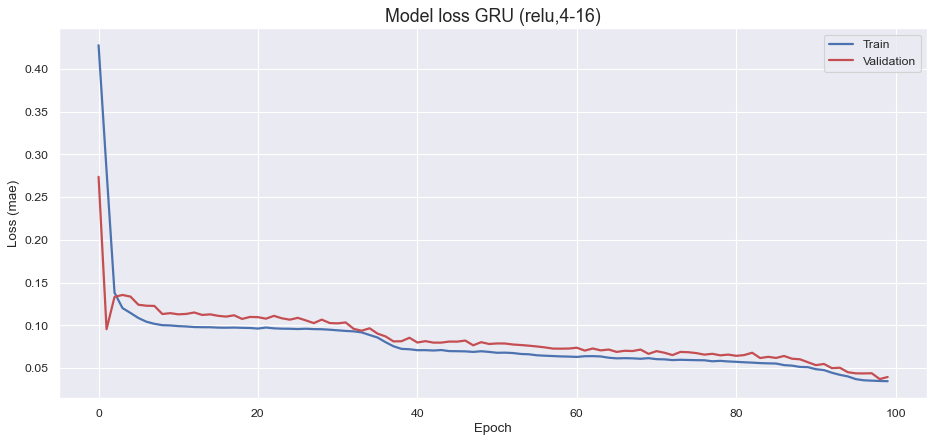

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 16)             1344      
                                                                 
 lstm_13 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_7 (RepeatVec  (None, 1, 4)              0         
 tor)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_15 (LSTM)              (None, 1, 16)             1344      
                                                           

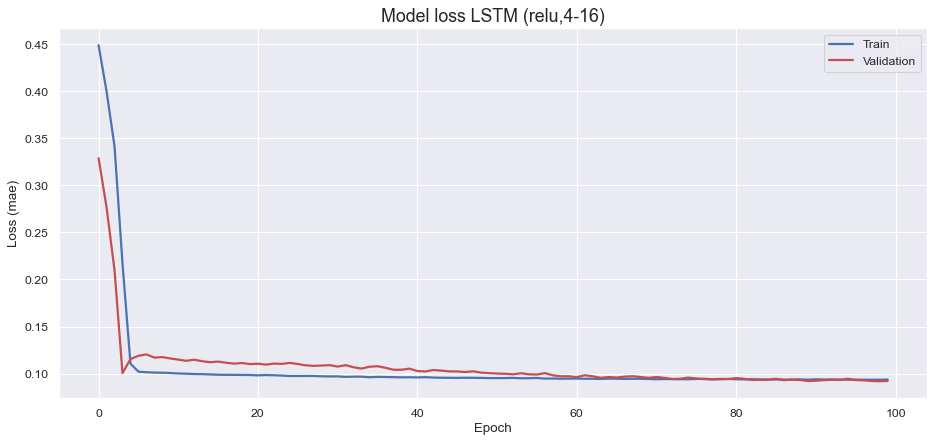

17/17 [==============================] - 0s 2ms/step
RSME GRU =  5.538579958573153
RSME LSTM =  6.96759871899773


In [11]:
#autoencoder with GRU layers
#definiton of the model
def autoencoder_GRU(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(16,activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(4,activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(4,activation='relu', return_sequences=True)(L3)
    L5 = GRU(16,activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model_GRU = autoencoder_GRU(X_train)
model_GRU.compile(optimizer = 'adam', loss = 'mae')
model_GRU.summary()

nb_epochs = 100
batch_size = 10
history_GRU = model_GRU.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

#plot losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_GRU['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_GRU['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss GRU (relu,4-16)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# autoencoder with LSTM layers
#definiton of the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss LSTM (relu,4-16)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_pred_test_GRU = model_GRU.predict(X_test)
X_pred_test_GRU = X_pred_test_GRU.reshape(X_pred_test_GRU.shape[0], X_pred_test_GRU.shape[2])
X_pred_test_GRU = pd.DataFrame(X_pred_test_GRU, columns=test.columns)
X_pred_test_GRU.index = test.index

X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index


RSME_LSTM = np.sqrt(mean_squared_error(Xtest,X_pred_test))
RSME_GRU = np.sqrt(mean_squared_error(Xtest,X_pred_test_GRU))

print("RSME GRU = ",RSME_GRU)
print("RSME LSTM = ",RSME_LSTM)

Activation function: relu

Number of cells/units: 16-32

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 gru_16 (GRU)                (None, 1, 32)             3648      
                                                                 
 gru_17 (GRU)                (None, 16)                2400      
                                                                 
 repeat_vector_8 (RepeatVec  (None, 1, 16)             0         
 tor)                                                            
                                                                 
 gru_18 (GRU)                (None, 1, 16)             1632      
                                                                 
 gru_19 (GRU)                (None, 1, 32)             4800      
                                                           

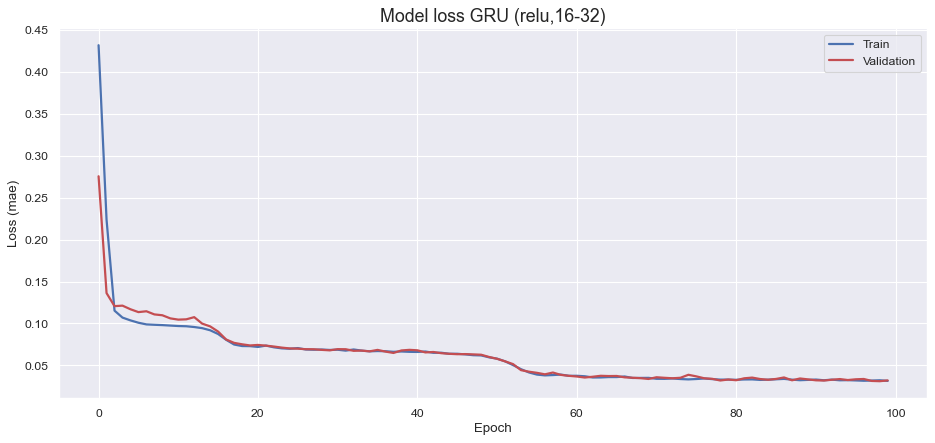

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 4)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_9 (RepeatVec  (None, 1, 16)             0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 1, 16)             2112      
                                                                 
 lstm_19 (LSTM)              (None, 1, 32)             6272      
                                                           

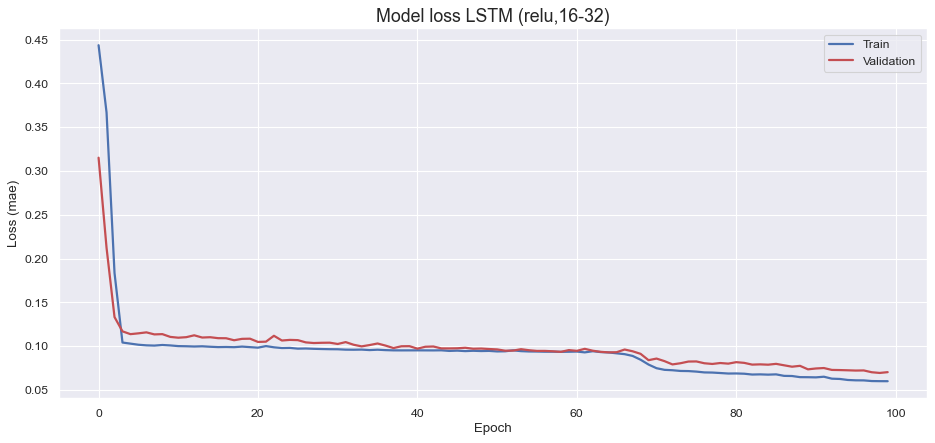

17/17 [==============================] - 0s 2ms/step
RSME GRU =  5.650268140182316
RSME LSTM =  5.41314944741102


In [12]:
#autoencoder with GRU layers
#definiton of the model
def autoencoder_GRU(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(32,activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = GRU(16,activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = GRU(16,activation='relu', return_sequences=True)(L3)
    L5 = GRU(32,activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model_GRU = autoencoder_GRU(X_train)
model_GRU.compile(optimizer = 'adam', loss = 'mae')
model_GRU.summary()

nb_epochs = 100
batch_size = 10
history_GRU = model_GRU.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

#plot losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history_GRU['loss'], 'b', label='Train', linewidth=2)
ax.plot(history_GRU['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss GRU (relu,16-32)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


# autoencoder with LSTM layers
#definiton of the model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss LSTM (relu,16-32)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
X_pred_test_GRU = model_GRU.predict(X_test)
X_pred_test_GRU = X_pred_test_GRU.reshape(X_pred_test_GRU.shape[0], X_pred_test_GRU.shape[2])
X_pred_test_GRU = pd.DataFrame(X_pred_test_GRU, columns=test.columns)
X_pred_test_GRU.index = test.index

X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=test.columns)
X_pred_test.index = test.index


RSME_LSTM = np.sqrt(mean_squared_error(Xtest,X_pred_test))
RSME_GRU = np.sqrt(mean_squared_error(Xtest,X_pred_test_GRU))

print("RSME GRU = ",RSME_GRU)
print("RSME LSTM = ",RSME_LSTM)

LSTM model presents the lowest RSME value, yet the separation of the curves between 80 and 100 epochs might be a sign of "overtrain": at that point the model is too specialized and will well predict only train data, making the model useless in the process of any new data. For this reason we did not use this configuration.